## Update the ERSST Sea Surface Temperature (raw and detrended version)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import pathlib

In [4]:
import numpy as np
import xarray as xr

### some parameters 

In [5]:
time_slice = {"time":slice("1948","2021")}
dict_rename = {'lat':'latitudes', 'lon':'longitudes'}

### first check the format of the existing ERSST dataset 

#### Note that there are 2 versions, detrended and non-detrended 

In [6]:
dset = xr.open_dataset('/media/nicolasf/END19101/data/PICT/datasets/ERSST/ERSST_monthly_SST_1948_2014.nc')

In [7]:
dset

<xarray.Dataset>
Dimensions:     (time: 803, latitudes: 89, longitudes: 180)
Coordinates:
  * longitudes  (longitudes) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitudes   (latitudes) float32 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0
  * time        (time) datetime64[ns] 1948-02-15 1948-03-15 ... 2014-12-15
Data variables:
    sst         (time, latitudes, longitudes) float64 ...
    mask        (latitudes, longitudes) int64 ...

### ERSST on OpenDAP (NCDC Thredds server)

In [8]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"	

In [9]:
ersst = xr.open_dataset(url, drop_variables=["time_bnds"])

In [10]:
ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2024)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-09-05
    DODS_EXTRA.Unlimited_Dimension:  time

In [11]:
ersst = ersst.rename(dict_rename)

In [12]:
ersst = ersst.sel(time_slice)

In [13]:
ersst

<xarray.Dataset>
Dimensions:     (latitudes: 89, longitudes: 180, time: 888)
Coordinates:
  * latitudes   (latitudes) float32 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * longitudes  (longitudes) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time        (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Data variables:
    sst         (time, latitudes, longitudes) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-09-05
    DODS_EXTRA.Unlimited_Dimension:  time

### creates a land/sea mask 

In [14]:
mask = ersst.sum('time')

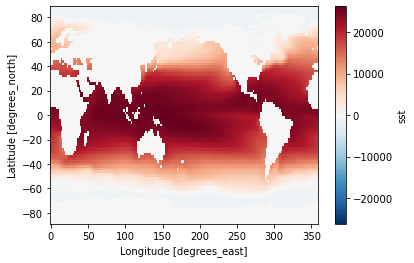

In [15]:
mask['sst'].plot()

In [16]:
mask = mask.where(mask==0, other=1)['sst']

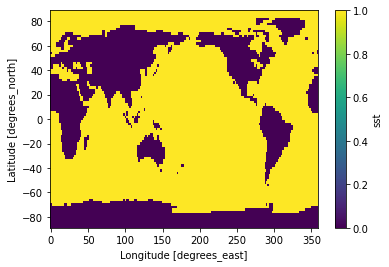

In [17]:
mask.plot()

In [18]:
mask = 1 - mask

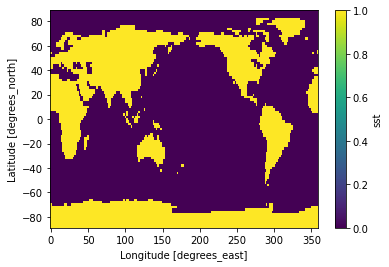

In [19]:
mask.plot()

In [20]:
# dset['mask'].plot()

### make a detrended version of the dataset 

In [21]:
p = ersst['sst'].polyfit(dim='time', deg=1)

In [22]:
p

<xarray.Dataset>
Dimensions:               (latitudes: 89, longitudes: 180, degree: 2)
Coordinates:
  * latitudes             (latitudes) float64 88.0 86.0 84.0 ... -86.0 -88.0
  * longitudes            (longitudes) float64 0.0 2.0 4.0 ... 354.0 356.0 358.0
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, latitudes, longitudes) float64 9.298e-22 ....

In [23]:
fit = xr.polyval(ersst['time'], p.polyfit_coefficients)

### average global trend 

In [24]:
m_trend = fit.mean(dim=['latitudes','longitudes'])

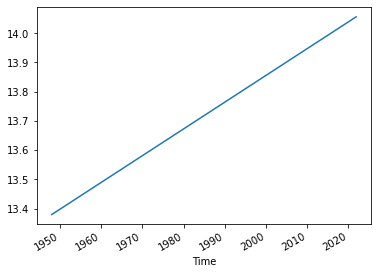

In [25]:
m_trend.plot()

### quick plots at the beginning and end of the dataset + difference

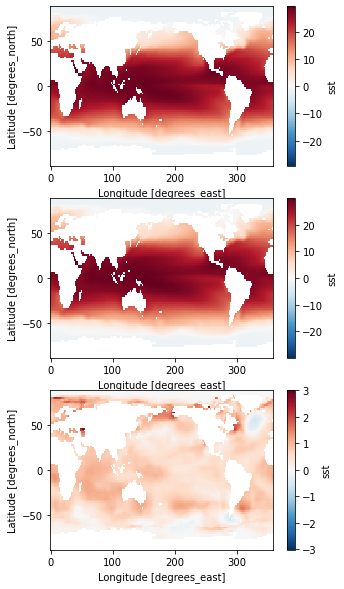

In [26]:
f, ax = plt.subplots(nrows=3, figsize=(5,10))
ersst.sel(time=slice('1950','1960')).mean('time')['sst'].plot(ax=ax[0])
ersst.sel(time=slice('2010','2020')).mean('time')['sst'].plot(ax=ax[1])
(ersst.sel(time=slice('2010','2020')).mean('time') - ersst.sel(time=slice('1950','1960')).mean('time'))['sst'].plot(ax=ax[2])

### Now calculate anomalies and detrend

In [27]:
ersst_detrend = (ersst[['sst']] - fit) + ersst[['sst']].mean('time')

In [28]:
ersst_detrend

<xarray.Dataset>
Dimensions:     (latitudes: 89, longitudes: 180, time: 888)
Coordinates:
  * latitudes   (latitudes) float32 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * longitudes  (longitudes) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time        (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Data variables:
    sst         (time, latitudes, longitudes) float64 -1.799 -1.799 ... nan nan

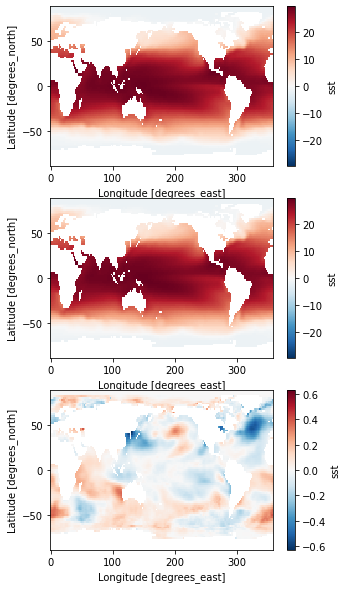

In [29]:
f, ax = plt.subplots(nrows=3, figsize=(5,10))
ersst_detrend.sel(time=slice('1950','1960')).mean('time')['sst'].plot(ax=ax[0])
ersst_detrend.sel(time=slice('2010','2020')).mean('time')['sst'].plot(ax=ax[1])
(ersst_detrend.sel(time=slice('2010','2020')).mean('time') - ersst_detrend.sel(time=slice('1950','1960')).mean('time'))['sst'].plot(ax=ax[2])

### adds the mask to the updated versions (detrended and non-detrended)

In [30]:
ersst['mask'] = mask
ersst_detrend['mask'] = mask

### saves to disk the 2 versions, will need to update the code 

In [31]:
ersst.to_netcdf('/media/nicolasf/END19101/data/PICT/datasets/ERSST/ERSST_monthly_SST_1948_2021.nc')

In [39]:
ersst.to_netcdf('/media/nicolasf/END19101/data/PICT/datasets/ERSST/ERSST_monthly_SST_1948_2021_detrend.nc')